# POPPY Simulation: MagAO-X Surface Check (Master file)
## Notes: 
- This file has aberrations present due to PSDs on the optical surfaces.
- This version uses a CSV file to make an easier time to analyze the diffraction effect initiated by each optical surface and to allow for optical system changes. 
- There are different CSV files to evaluate different setups; each CSV file may be found in the data folder.
- The function definitions used in this file may be found here: https://github.com/jlumbres/magaox_poppy/blob/master/magaoxFunctions.py
- There are a lot of pink warnings present in this notebook. Please ignore them, they are a POPPY thing and do not affect the output.
- The FITS files generated in code (DM surfaces, PSF intensities at science plane) are not included in github because they are too large for github's storage space. However, one may obtain them by running this code.

## Major Update:
- The Science PSFs have been changed from PDR level. The PDR level notebooks was doubling the phase in the vAPP OPD mask and not allowing a full transmission for the vAPP transmission mask. This notebook has since corrected it.

In [1]:
%matplotlib inline
#load modules
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from astropy import units as u
from astropy.io import fits
from  matplotlib.colors import LogNorm
import scipy.ndimage
#POPPY
import poppy
from poppy.poppy_core import PlaneType
print("POPPY Version: "+poppy.__version__)
#silence DEBUG and WARNINGs
import logging
logging.getLogger('poppy').setLevel(logging.ERROR)
# MagAO-X function definitions
import magaoxFunctions as mf

POPPY Version: 0.6.0rc1


## Initiate the optical elements and variables
- The values for the Magellan telescope and MagAO-X are pulled from Oli Durney's Zemax file. All distances between each MagAO-X element (after F/11 focal plane) can be found using Zemax Merit Function Editor (using RAG and QSUM)
- Current Zemax design version: 9.5

### Optical elements not implemented:
- ADC1
- ADC2
- 9mm Lyot Stop
- F-4 and F-5 (for version 9.5)

### To-do Tasks:
- Test against new surface maps.

## Task 0: CSV Prescription Load

The system is stored as a CSV file describing each optics prescription and the distance between them. The CSV file also contains the surface map PSD files for each optical surface. At each F/number focal plane, the correction value has already been implemented, as defined from a previous file build.

In [2]:
rx_sys = mf.makeRxCSV('data/rxCSV/rx_magaox_v9.5_PSDset2.csv')

CSV file name: data/rxCSV/rx_magaox_v9.5_PSDset2.csv
The names of the headers are:
('Optical_Element_Number', 'Name', 'Type', 'Focal_Length_m', 'Distance_m', 'Radius_m', 'surf_PSD_folder', 'surf_PSD_filename', 'optic_type', 'OPD_unit', 'Correction_m', 'Comment')


Build the array that only calls for the mirrors (only the mirrors have the surfaces to examine)

In [3]:
mirrors_array = []
optics_names = []
for t_optic, test_opt in enumerate(rx_sys):
    if test_opt['Type'] == 'mirror' or test_opt['Type'] == 'ref':
        mirrors_array.append(test_opt['Optical_Element_Number'])
        optics_names.append(test_opt['Name'])
        if test_opt['Type'] == 'ref':
            ref_num = test_opt['Optical_Element_Number']
    elif test_opt['Name'] == 'Tweeter':
        tweeter_num = test_opt['Optical_Element_Number']
    elif test_opt['Name'] == 'vAPP-trans':
        vappTRANS_num = test_opt['Optical_Element_Number']
    elif test_opt['Name'] == 'vAPP-opd':
        vappOPD_num = test_opt['Optical_Element_Number']
    
    if test_opt['Name'] == 'M1':
        M1_num = test_opt['Optical_Element_Number']
        
telescope = mirrors_array

## Global variables for MagAO-X
<b>Current Setting</b>: 256 pix sample, 8x oversample; All files below are particular for this setting.

<b>PDR Level</b>: 512 pix sample, 3x oversample (holdover from PROPER examples)

In [4]:
# Global terms
# note: u.m is in meters
testWavelength = 656e-9 * u.m # H-alpha
npix = 256  # sampling
beam_ratio = 0.125 # 8x oversample
M1_radius=rx_sys['Radius_m'][M1_num]*u.m

# vAPP files
vAPP_diam = 0.009 # units: meters, always 9mm diameter beam.
vAPP_pixelscl = vAPP_diam/npix # vAPP is sized to whatever the sampling is set.
vAPP_folder = 'data/coronagraph/'
vAPP_trans_filename = 'vAPP_trans_mask_1PSF_256'
vAPP_opd_filename = 'vAPP_opd_mask_1PSF_256'

# Lyot plane pupil file
lyot_pupil_base = fits.open('data/PSDset2/MagAOX_f11_pupil_256_unmasked.fits')[0].data

# Spatial Frequency mapping routine
magKmap = mf.SpatFreqMap(M1_radius, npix)

# Tweeter DM control bandwidth
tweeter_BW = 24/(M1_radius.value*2)

# Tweeter DM diameter - from MagAO-X design: 19.2 x 18.8mm; use the smaller one
tweeter_diam = 0.0188 * u.m

## Preparing vAPP files
Here only for reference. Skip if the locations have been determined prior.

In [ ]:
vapp_phase_data = fits.open('data/coronagraph/MagAOx_256x256_phase_nograting.fits')[0].data
vapp_aperture_data = fits.open('data/coronagraph/MagAOx_256x256_amp.fits')[0].data

vAPP_folder = 'data/coronagraph/'

vapp_opd_surf_data = 1*(testWavelength.value/(2*np.pi))*vapp_phase_data*vapp_aperture_data
vAPP_opd_filename = 'vAPP_opd_mask_1PSF_256'
mf.vappOPDfile(vapp_opd_surf_data, vAPP_pixelscl, vAPP_folder + vAPP_opd_filename + '.fits')

vAPP_trans_filename = 'vAPP_trans_mask_1PSF_256'
mf.vappTRANSfile(vapp_aperture_data, vAPP_pixelscl, vAPP_folder + vAPP_trans_filename + '.fits')

## Version: DM implemented

In [5]:
%%prun

# File address locations
tweeter_surf_folder = 'data/v9.5/s256os8x/set2/'
rx_sys['surf_PSD_folder'][tweeter_num] = tweeter_surf_folder
tweeter_surf_prefix = 'DMsurf_'
sci_intensity_folder = 'output/v9.5/s256os8x/set2/WithDM/'
sci_intensity_prefix = 'SciPSF_WithDM_intensity_'

print('Surface check using sampling = %f px and oversampling = %f' % (npix, 1/beam_ratio))
print('*****')

for test_optic in telescope:
    print('Build MagAO-X removing surface: %s' % rx_sys['Name'][test_optic])
    
    # Remove test optic PSD and hold the value to change at loop end
    hold_test_PSD = rx_sys['surf_PSD_filename'][test_optic]
    rx_sys['surf_PSD_filename'][test_optic] = 'none'
    
    # build to Lyot plane
    magaox = mf.csvFresnel(rx_sys, npix, beam_ratio, 'lyot')
    lyot_psf, lyot_wfs = magaox.calcPSF(wavelength=testWavelength,
                                    display_intermediates=False,
                                    return_intermediates=True)
    lyot_phase_plane_data = lyot_wfs[len(lyot_wfs)-1].asFITS('phase')[0].data
    
    # Build Lyot DM surface map routine; spatial plane must be built prior to for-loop
    tweeter_surf_file_loc = tweeter_surf_folder + tweeter_surf_prefix + rx_sys['Name'][test_optic]
    mf.BuildLyotDMSurf(lyot_phase_plane_data, npix, tweeter_diam, lyot_pupil_base, magKmap, tweeter_BW, 
                       testWavelength, tweeter_surf_file_loc)
    
    # Insert Lyot DM map vAPP transmission and OPD optics overrides
    rx_sys['surf_PSD_filename'][tweeter_num] = tweeter_surf_prefix + rx_sys['Name'][test_optic]
    rx_sys['surf_PSD_filename'][vappTRANS_num] = vAPP_trans_filename
    rx_sys['surf_PSD_filename'][vappOPD_num] = vAPP_opd_filename
    
    # Build science plane PSF with DM and vAPP 
    magaox = mf.csvFresnel(rx_sys, npix, beam_ratio, 'sci')   
    sci_psf = magaox.calcPSF(wavelength=testWavelength, 
                             display_intermediates=False,
                             return_intermediates=False)
    sci_intensity_loc = sci_intensity_folder + sci_intensity_prefix + rx_sys['Name'][test_optic] + '.fits'
    sci_psf.writeto(sci_intensity_loc, clobber=True)
    
    # reset corrected optical surfaces
    rx_sys['surf_PSD_filename'][test_optic] = hold_test_PSD
    rx_sys['surf_PSD_filename'][tweeter_num] = 'none'
    rx_sys['surf_PSD_filename'][vappTRANS_num] = 'none'
    rx_sys['surf_PSD_filename'][vappOPD_num] = 'none'

    print('End test for %s surface' % rx_sys['Name'][test_optic])
    print('*****')

Surface check using sampling = 256.000000 px and oversampling = 8.000000
*****
Build MagAO-X removing surface: M1


/home/jhen/anaconda3/lib/python3.5/site-packages/poppy-0.6.0rc1-py3.5.egg/poppy/poppy_core.py:2284: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self._resampled_opd[border_x:border_x+resampled_opd.shape[0],border_y:border_y+resampled_opd.shape[1]] = resampled_opd
/home/jhen/anaconda3/lib/python3.5/site-packages/poppy-0.6.0rc1-py3.5.egg/poppy/poppy_core.py:2285: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self._resampled_amplitude[border_x:border_x+resampled_opd.shape[0],border_y:border_y+resampled_opd.shape[1]]=resampled_amplitude
/home/jhen/anaconda3/lib/python3.5/site-packages/scipy/ndimage/interpolation.py:568: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
/home/jhen/anaconda

End test for M1 surface
*****
Build MagAO-X removing surface: M2
End test for M2 surface
*****
Build MagAO-X removing surface: M3
End test for M3 surface
*****
Build MagAO-X removing surface: F-1
End test for F-1 surface
*****
Build MagAO-X removing surface: K-1
End test for K-1 surface
*****
Build MagAO-X removing surface: K-2
End test for K-2 surface
*****
Build MagAO-X removing surface: K-3
End test for K-3 surface
*****
Build MagAO-X removing surface: F-2
End test for F-2 surface
*****
Build MagAO-X removing surface: OAP-0
End test for OAP-0 surface
*****
Build MagAO-X removing surface: OAP-1
End test for OAP-1 surface
*****
Build MagAO-X removing surface: F-3
End test for F-3 surface
*****
Build MagAO-X removing surface: OAP-2
End test for OAP-2 surface
*****
Build MagAO-X removing surface: OAP-3
End test for OAP-3 surface
*****
Build MagAO-X removing surface: F-4
End test for F-4 surface
*****
Build MagAO-X removing surface: F-5
End test for F-5 surface
*****
Build MagAO-X removi

## Version: Without DM

In [6]:
%%prun
# File address locations
sci_intensity_folder = 'output/v9.5/s256os8x/set2/WithoutDM/'
sci_intensity_prefix = 'SciPSF_WithoutDM_intensity_'

# Insert vAPP transmission and OPD optics overrides
print('Override vAPP OPD and transmission PSD maps for WithoutDM case')
rx_sys['surf_PSD_filename'][vappTRANS_num] = vAPP_trans_filename
rx_sys['surf_PSD_filename'][vappOPD_num] = vAPP_opd_filename

# Make sure there is no surface map on tweeter DM
rx_sys['surf_PSD_filename'][tweeter_num] = 'none'

print('Surface check (Without DM) using sampling = %f px and oversampling = %f' % (npix, 1/beam_ratio))
print('*****')

for test_optic in telescope:
    print('Build MagAO-X removing %s surface without DM' % rx_sys['Name'][test_optic])
    
    # Remove test optic PSD and hold the value to change at loop end
    hold_test_PSD = rx_sys['surf_PSD_filename'][test_optic]
    rx_sys['surf_PSD_filename'][test_optic] = 'none'
    
    # Build science plane PSF with DM and vAPP 
    magaox = mf.csvFresnel(rx_sys, npix, beam_ratio, 'sci')   
    sci_psf = magaox.calcPSF(wavelength=testWavelength, 
                             display_intermediates=False,
                             return_intermediates=False)
    sci_intensity_loc = sci_intensity_folder + sci_intensity_prefix + rx_sys['Name'][test_optic] + '.fits'
    sci_psf.writeto(sci_intensity_loc, clobber=True)
    
    # reset corrected optical surfaces
    rx_sys['surf_PSD_filename'][test_optic] = hold_test_PSD

    print('End test for %s surface (without DM)' % rx_sys['Name'][test_optic])
    print('*****')
    
# Reset rx_sys filenames for vAPP to look like original setup
print('Reset vAPP OPD and transmission PSD maps back to "none"')
rx_sys['surf_PSD_filename'][vappTRANS_num] = 'none'
rx_sys['surf_PSD_filename'][vappOPD_num] = 'none'

Override vAPP OPD and transmission PSD maps for WithoutDM case
Surface check (Without DM) using sampling = 256.000000 px and oversampling = 8.000000
*****
Build MagAO-X removing M1 surface without DM


/home/jhen/anaconda3/lib/python3.5/site-packages/poppy-0.6.0rc1-py3.5.egg/poppy/poppy_core.py:2284: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self._resampled_opd[border_x:border_x+resampled_opd.shape[0],border_y:border_y+resampled_opd.shape[1]] = resampled_opd
/home/jhen/anaconda3/lib/python3.5/site-packages/poppy-0.6.0rc1-py3.5.egg/poppy/poppy_core.py:2285: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self._resampled_amplitude[border_x:border_x+resampled_opd.shape[0],border_y:border_y+resampled_opd.shape[1]]=resampled_amplitude
/home/jhen/anaconda3/lib/python3.5/site-packages/scipy/ndimage/interpolation.py:568: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
/home/jhen/anaconda

End test for M1 surface (without DM)
*****
Build MagAO-X removing M2 surface without DM
End test for M2 surface (without DM)
*****
Build MagAO-X removing M3 surface without DM
End test for M3 surface (without DM)
*****
Build MagAO-X removing F-1 surface without DM
End test for F-1 surface (without DM)
*****
Build MagAO-X removing K-1 surface without DM
End test for K-1 surface (without DM)
*****
Build MagAO-X removing K-2 surface without DM
End test for K-2 surface (without DM)
*****
Build MagAO-X removing K-3 surface without DM
End test for K-3 surface (without DM)
*****
Build MagAO-X removing F-2 surface without DM
End test for F-2 surface (without DM)
*****
Build MagAO-X removing OAP-0 surface without DM
End test for OAP-0 surface (without DM)
*****
Build MagAO-X removing OAP-1 surface without DM
End test for OAP-1 surface (without DM)
*****
Build MagAO-X removing F-3 surface without DM
End test for F-3 surface (without DM)
*****
Build MagAO-X removing OAP-2 surface without DM
End t

# Task: Check flux in small region of dark hole
The goal of this task is to see how the surface map on each optical element affects the Dark Hole (DH) in the Science PSF. This will determine if certain optics will require more money to be spent for better surface quality.

Each optical element with a surface will be evaluated to determine a list of offenders. The offender is determined by the DH flux change relative to the reference (no surfaces removed) DH flux. A large dip in the DH flux indicates removing the optic's surface creates worse (higher) contrast. 

Additionally, there are cases where removing the surface increases the flux, meaning the surface creates a better (lower) contrast. This case is not physical and likely a numerical noise problem. This is currently being evaluated, with several options such as generating new (random) surfaces, adjusting the sampling and oversampling values (from 512px sample at 3x oversample to 256px sample at 8x oversample), and adjusting the pixelscale values placed on each surface.

Each evaluation includes the vAPP coronagraph and with/without a DM correction.

In [7]:
# Dark Hole geometry from ds9, for 256pix sample at 8x oversample setup
center_pix = [1023.5, 970.5] # changed for 54x54 size region
shift=26.5 # hardcoded for 54x54 size region

# calculated from a previous iteration
set1_PSF_withDM_loc = 'output/v9.5/s256os8x/set1/WithDM/SciPSF_WithDM_s256os8x_intensity_'
set1_PSF_withoutDM_loc = 'output/v9.5/s256os8x/set1/WithoutDM/SciPSF_WithoutDM_s256os8x_intensity_'

set2_PSF_withDM_loc = 'output/v9.5/s256os8x/set2/WithDM/SciPSF_WithDM_intensity_'
set2_PSF_withoutDM_loc = 'output/v9.5/s256os8x/set2/WithoutDM/SciPSF_WithoutDM_intensity_'

# run a line here of code for filling up the array
set1_withDM_avg, set1_withDM_avg_ref = mf.calcFluxDH_List(set1_PSF_withDM_loc, center_pix, shift, 
                                                          optics_names, 'mean')
set1_withoutDM_avg, set1_withoutDM_avg_ref = mf.calcFluxDH_List(set1_PSF_withoutDM_loc, center_pix, shift, 
                                                          optics_names, 'mean')
set2_withDM_avg, set2_withDM_avg_ref = mf.calcFluxDH_List(set2_PSF_withDM_loc, center_pix, shift, 
                                                          optics_names, 'mean')
set2_withoutDM_avg, set2_withoutDM_avg_ref = mf.calcFluxDH_List(set2_PSF_withoutDM_loc, center_pix, shift, 
                                                          optics_names, 'mean')

/home/jhen/Dropbox/OliLab/PythonScripts/MagAOX/magaoxFunctions.py:266: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  DH_region = contrast_img[DHside_low[0]:DHside_high[0],DHside_low[1]:DHside_high[1]]


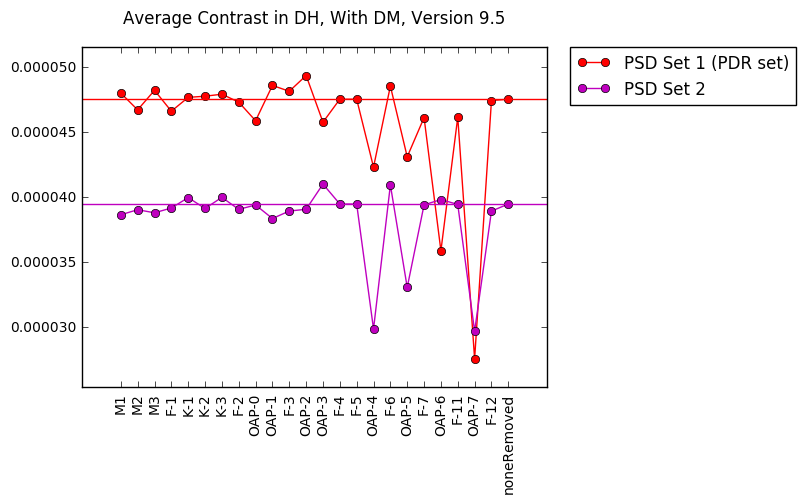

In [8]:
x=np.arange(len(optics_names))
plt.plot(x, set1_withDM_avg,'ro-', label='PSD Set 1 (PDR set)')
plt.plot(x, set2_withDM_avg, 'mo-', label='PSD Set 2')
plt.axhline(y=set1_withDM_avg_ref, color='r', linestyle='-')
plt.axhline(y=set2_withDM_avg_ref, color='m', linestyle='-')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xticks(x,optics_names,rotation='vertical')
plt.margins(0.1)
plt.subplots_adjust(top=1.0)
plt.subplots_adjust(bottom=0.15)
plt.title('Average Contrast in DH, With DM, Version 9.5',y=1.05)
plt.show()

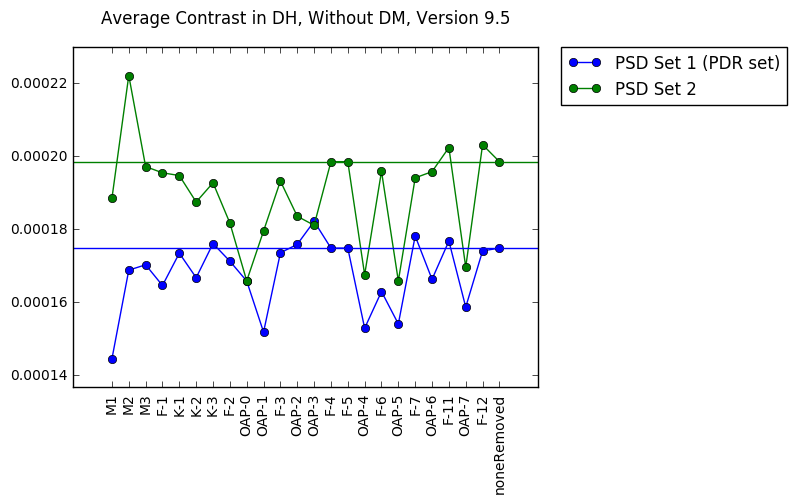

In [10]:
x=np.arange(len(optics_names))
plt.plot(x, set1_withoutDM_avg,'bo-', label='PSD Set 1 (PDR set)')
plt.plot(x, set2_withoutDM_avg, 'go-', label='PSD Set 2')
plt.axhline(y=set1_withoutDM_avg_ref, color='b', linestyle='-')
plt.axhline(y=set2_withoutDM_avg_ref, color='g', linestyle='-')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xticks(x,optics_names,rotation='vertical')
plt.margins(0.1)
plt.subplots_adjust(top=1.0)
plt.subplots_adjust(bottom=0.15)
plt.title('Average Contrast in DH, Without DM, Version 9.5',y=1.05)
plt.show()